## MODEL EVALUATION Examples

- treat it as your example / reference guide for the future
- the evaluation examples have been compiled by adopting code snippets from various sources. 
- there are many inline comments, which should guide you through these examples. 

## Adult Income dataset


<img src="data/images/adults.png" style="width:700px;">

- Let's use our previous dataset __Adults__
- This is the Classification example that we are faimilar with: predict if an adult's salary is <=50K or > 50K
- Interesting fact: this dataset was extracted from the 1994 Census database ¯\_(ツ)_/¯

In [1]:
# If you do not have these libraries, you will need to install them, using the `! pip install <package>` command, 
# replacing `<package>` with the name of the library to install.


#### Import core python libraries
import pandas as pd
import pickle
import os
import numpy as np
from IPython.display import Math
from itertools import product

#### Import machine learning and stats libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (auc, confusion_matrix, roc_curve, 
                             accuracy_score, precision_score)

##### Import visualisation libraries
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 12
import seaborn as sns
sns.set()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
"""
We need to load, process and prepare the Adults dataset AGAIN to be able to build and evaluate models. 

Below are familiar steps that we need to repeat one by one.

"""

# Upload the data 
df_raw = pd.read_csv("data/adult.csv", index_col=[0])

# Drop meaningless variables
df_raw = df_raw.drop(['fnlwgt'], axis=1)

# Majority of United-States occurrences, not useful
df_raw = df_raw.drop(['native.country'], axis=1)

# Scale numeric variables
numeric_cols = df_raw.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler()
df_raw.loc[:, numeric_cols] = scaler.fit_transform(df_raw.loc[:, numeric_cols])

# One-hot encode categorical variables 
one_hot_df = pd.get_dummies(df_raw, drop_first=True)

# Build dummy variable for working vs not working ('Without-pay')
for col in one_hot_df.columns:
    if 'workclass_' in col and ' Without-pay' not in col:
        one_hot_df = one_hot_df.drop([col], axis=1)
        
# Remove education-num as it is difficult to interpret (and we have other columns for education levels)
one_hot_df = one_hot_df.drop(['education.num'], axis=1)

# Splitting the data into training and testing sets - a frequent test set size is 20%-30% of the original dataset

target = one_hot_df['income_>50K']
one_hot_df_indep = one_hot_df.drop('income_>50K', axis=1)

X = one_hot_df_indep.values

X_train, X_test, y_train, y_test  = train_test_split(X, target, test_size = 0.2)

In [3]:
print(" X_train: {}\n X_test: {}\n y_train: {}\n y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

 X_train: (26048, 48)
 X_test: (6513, 48)
 y_train: (26048,)
 y_test: (6513,)


### MODEL TRAINING

- Let's train a few common models on our dataset
- Then we can compare their performances

In [4]:
# Decision tree 
clf_dt = DecisionTreeClassifier(criterion='gini', max_depth=10, min_samples_split=20, 
                             min_samples_leaf=10, max_features=None)
clf_dt.fit(X_train, y_train)
pred_clf_dt = clf_dt.predict(X_test)
proba_clf_dt = clf_dt.predict_proba(X_test)

In [5]:
# Random forest 
clf_rf = RandomForestClassifier(random_state = 33, n_estimators=50, max_depth=5, 
                                min_samples_leaf=30, max_features=4)
clf_rf.fit(X_train, y_train)
pred_clf_rf = clf_rf.predict(X_test)
proba_clf_rf = clf_rf.predict_proba(X_test)

In [6]:
# Logistic regression, so we can investigate ROC and AUC
clf_logit = LogisticRegression()
clf_logit.fit(X_train, y_train)
pred_clf_logit = clf_logit.predict(X_test)
proba_clf_logit = clf_logit.predict_proba(X_test)

In [7]:
# This gives the probabilities associated with labels 0 and 1, respectively
print(proba_clf_logit)

[[0.69601521 0.30398479]
 [0.2166961  0.7833039 ]
 [0.94437704 0.05562296]
 ...
 [0.97061222 0.02938778]
 [0.99769804 0.00230196]
 [0.93592569 0.06407431]]


In [8]:
# Setting thresholds

"""
In classification, we need to select a probability threshold, 
to determine which score enables you to discriminate the class 
to which you allocate your occurrence.

"""
# Note we want to use the second column [:,1] of the probabilities, as this corresponds
# with the probability that the target label = 1

thres = 0.5
target_predict_logit = np.where(proba_clf_logit[:,1] > thres, 1, 0)
target_predict_tree = np.where(proba_clf_dt[:,1] > thres, 1, 0)
target_predict_rf = np.where(proba_clf_rf[:,1] > thres, 1, 0)
target_actual = y_test

#### CONFUSION MATRIX


>The confusion matrix enables to have an overview of the performance of a classification predictive model, as it indicates >the number of events which were predicted correctly. 

* We define **>50k** to be *positive*, as our target contains the label `1` when `'income_>50K'` is true. 
* We define **<=50k** to be *negative*, as our target contains the label `0` when `'income_>50K'` is false. 

__Our 'buckets':__

* True Positive (TP): Model says positive, is actually positive 
* True Negative (TN): Model says negative, is actually negative 
* False Positive (FP): Model says positive, is actually negative
* False Negative (FN): Model says negative, is actually positive


In [9]:
# How many actual "positive" (e.g., >50k) cases do we have in our train/test dataset? 

# What % of each dataset does it make up?

train_pos_count = y_train.sum()
test_pos_count = y_test.sum()

print('% positive in train set (count/total): {:.2f}% ({}/{})'
      .format(train_pos_count * 100.0 / len(y_train), train_pos_count, len(y_train)))
print('% positive in test set (count/total): {:.2f}% ({}/{})'
      .format(test_pos_count * 100.0 / len(y_test), test_pos_count, len(y_test)))

% positive in train set (count/total): 24.02% (6258/26048)
% positive in test set (count/total): 24.31% (1583/6513)


In [10]:
# How many "positive" (e.g., >50k) cases do we predict with the logistic regression?

logit_pos_count = target_predict_logit.sum()
print('% positive in logistic predictions (count/total): {:.2f}% ({}/{})'
      .format(logit_pos_count * 100.0 / len(y_test), logit_pos_count, len(y_test)))

% positive in logistic predictions (count/total): 18.85% (1228/6513)


In [11]:
# This is a function to 'prettify' confusion matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          axis=1,
                          figsize=(5,4), 
                          fontsize=14,
                          cmap='Blues'):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    Note that normalization here by default occurs across axis=1, or across each row (true class). 
    """
    
    if normalize:
        if axis == 1:
            cm = cm.astype('float') / cm.sum(axis=axis)[:, np.newaxis] * 100
        elif axis == 0:
            cm = cm.astype('float') / cm.sum(axis=axis)[np.newaxis, :] * 100
        else:
            raise ValueError("axis must be 0 or 1")
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    
    fig = plt.figure(figsize=figsize)
    plt.grid(b=None)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    q_labels = ['TN', 'FP', 'FN', 'TP']
    quad_font_size = 14
    fmt = '.1f' if normalize else 'd'
    thresh = cm.max() / 2.
    q_i = 0
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        
        q = plt.text(j, i-0.2, q_labels[q_i], horizontalalignment='center', fontsize=quad_font_size)
        q_i += 1
        q.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))
        
        t = plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                     verticalalignment="center",
                 color="#002781",
                    fontsize=fontsize)
        t.set_bbox(dict(facecolor='white', alpha=0.6, edgecolor='white'))
        

    plt.tight_layout(h_pad=10, w_pad=0)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return None

##### Evaluate logistic regression model

Confusion matrix, without normalization
[[4615  315]
 [ 670  913]]
Normalized confusion matrix
[[93.61054767  6.38945233]
 [42.32469994 57.67530006]]


<Figure size 432x288 with 0 Axes>

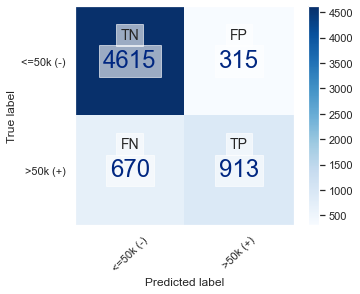

<Figure size 432x288 with 0 Axes>

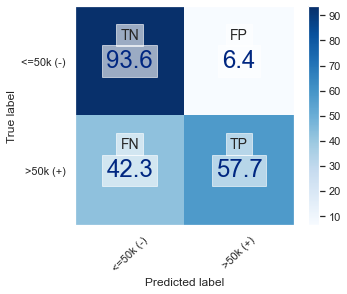

<Figure size 432x288 with 0 Axes>

In [12]:
class_names = ['<=50k (-)', '>50k (+)']
fontsize=24
figsize=(5,4)

# Plot the confusion matrix of the logistic regression
logit_cfn = confusion_matrix(target_actual, target_predict_logit)
log_tn, log_fn, log_fp, log_tp = confusion_matrix(target_actual, target_predict_logit).ravel()


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(logit_cfn, classes=class_names, 
                      normalize=False, figsize=figsize, fontsize=fontsize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(logit_cfn, classes=class_names, 
                      normalize=True, figsize=figsize, fontsize=fontsize)

plt.show()
plt.tight_layout()

##### Evaluate decision tree model

Confusion matrix, without normalization
[[4662  268]
 [ 681  902]]
Normalized confusion matrix
[[94.56389452  5.43610548]
 [43.01958307 56.98041693]]


<Figure size 432x288 with 0 Axes>

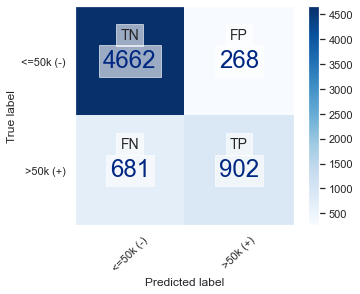

<Figure size 432x288 with 0 Axes>

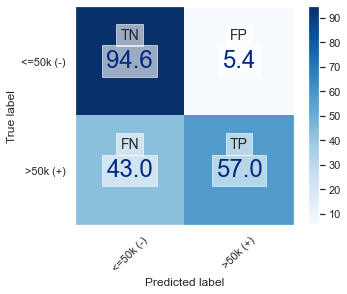

In [13]:
# Plot the confusion matrix for the decision tree
tree_cfn = confusion_matrix(target_actual, target_predict_tree)
tree_tn, tree_fn, tree_fp, tree_tp = confusion_matrix(target_actual, target_predict_tree).ravel()

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(tree_cfn, classes=class_names, 
                      normalize=False, figsize=figsize, fontsize=fontsize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(tree_cfn, classes=class_names, 
                      normalize=True, figsize=figsize, fontsize=fontsize)

##### Evaluate random forest model

Confusion matrix, without normalization
[[4924    6]
 [1228  355]]
Normalized confusion matrix
[[99.87829615  0.12170385]
 [77.57422615 22.42577385]]


<Figure size 432x288 with 0 Axes>

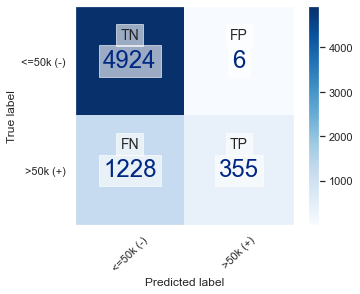

<Figure size 432x288 with 0 Axes>

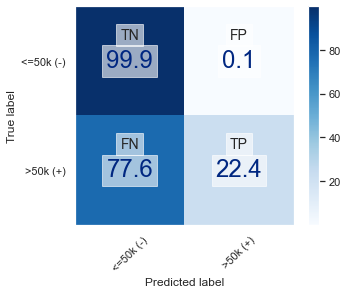

In [14]:
# Plot the confusion matrix for the decision tree
rf_cfn = confusion_matrix(target_actual, target_predict_rf)
rf_tn, rf_fn, rf_fp, rf_tp = confusion_matrix(target_actual, target_predict_rf).ravel()

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(rf_cfn, classes=class_names, 
                      normalize=False, figsize=figsize, fontsize=fontsize)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(rf_cfn, classes=class_names, 
                      normalize=True, figsize=figsize, fontsize=fontsize)

In [15]:
# ACCURACY

log_acc = round((log_tp + log_tn) / X_test.shape[0], 3) * 100
tr_acc = round((tree_tp + tree_tn) / X_test.shape[0], 3) * 100
rf_acc = round((rf_tp + rf_tn) / X_test.shape[0], 3) * 100

print('Logistic regression accuracy: {:.2f}%'.format(log_acc))
print('Decision tree accuracy: {:.2f}%'.format(tr_acc))
print('Random forest accuracy: {:.2f}%'.format(rf_acc))

Logistic regression accuracy: 84.90%
Decision tree accuracy: 85.40%
Random forest accuracy: 81.10%


In [16]:
#PRECISION

log_precision = round((log_tp / (log_tp + log_fp)), 2) * 100
tr_precision = round((tree_tp / (tree_tp + tree_fp)), 2) * 100
rf_precision = round((rf_tp / (rf_tp + rf_fp)), 2) * 100

print('Logistic regression precision: {:.2f}%'.format(log_precision))
print('Decision tree precision: {:.2f}%'.format(tr_precision))
print('Random forest precision: {:.2f}%'.format(rf_precision))

Logistic regression precision: 58.00%
Decision tree precision: 57.00%
Random forest precision: 22.00%
